## Sentiment Analysis of Stocks from Financial News

<p>In this project, we generate investing insight by applying <a href="https://en.wikipedia.org/wiki/Sentiment_analysis">sentiment analysis</a> on financial news headlines from <a href="https://finviz.com">FINVIZ.com</a>.

 <a href="https://en.wikipedia.org/wiki/Natural_language_processing">Natural Language Processing</a> can be leveraged to  understand the emotion behind the headlines of a particular stock/organization and predict the market sentiment for it. It would then be possible to make educated guesses on how certain stocks will perform and trade accordingly. 


## 1. Reading data from the dataset folder
 

In [2]:

from bs4 import BeautifulSoup
import os

html_tables = {}

for table_name in os.listdir('datasets'):
    
    table_path = f'datasets/{table_name}'
    
    table_file = open(table_path, 'r')
    
    html = BeautifulSoup(table_file)
    
    html_table = html.find(id='news-table')
    html_tables[table_name] = html_table

## 2. Exploring the headlines table


In [3]:
tsla = html_tables['tsla_22sep.html']

tsla_tr = tsla.findAll('tr')


for i, table_row in enumerate(tsla_tr):
    
    link_text = table_row.a.get_text()
    
    data_text = table_row.td.get_text()
    
    print(f'File number {i+1}:')
     
    print(link_text)
    print(data_text)
    
    if i == 3:
        break



File number 1:
Billionaire investor questions Elon Musk getting 'a pass' after bombshell tweets
Sep-21-18 09:56PM  
File number 2:
Broadcoms Stock Looks Like a Winner
09:30PM  
File number 3:
SHAREHOLDER ALERT:Â  Pomerantz Law Firm Reminds Shareholders with Losses on their Investment in Tesla, Inc. of Class Action Lawsuit and Upcoming Deadline  TSLA
05:30PM  
File number 4:
Tesla's People Problem and the Inscrutable Musk: 2 Things That Make You Go Hmmm
05:30PM  


## 3. Extract the news headlines
<p>We could see that the relevant data inside each table row (<code>&lt;tr&gt;</code>) is in the text inside the <code>&lt;td&gt;</code> and <code>&lt;a&gt;</code> tags. Parsing data for all tables in the dataset.
    

In [4]:

parsed_news = []

for file_name, news_table in html_tables.items():
    # Iterating through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # Read the text from the tr tag into text
        text = x.get_text() 
        # Split the text in the td tag into a list 
        date_scrape = x.td.text.split()
        
        if len(date_scrape) == 1:
            time = date_scrape[0]
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        
        
        headline = x.a.get_text()
        
          
        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, headline])


## 4. Sentiment Analysis using NLTK Vader
NLTK Vader will be tweaked for financial world by adding some new words and sentiment values to our lexicon.</p>
This is done so that we have a contextual understanding of the information provided in the headlines.

In [9]:
! pip install nltk
! python -m nltk.downloader vader_lexicon

from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Adding new words and values
new_words = {
    'crushes': 10,
    'beats': 5,
    'misses': -5,
    'trouble': -10,
    'falls': -100,
}
# Instantiate the sentiment intensity analyzer with the existing lexicon
vader = SentimentIntensityAnalyzer()
# Update the lexicon
vader.lexicon.update(new_words)


C:\Users\Krishnaditya\anaconda3\lib\runpy.py:127: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Krishnaditya\AppData\Roaming\nltk_data...


## 5. Predicting sentiment out of news headlines.
<p>Now that we have the data and the algorithm loaded, we will get to the core of the matter: programmatically predicting sentiment out of news headlines

In [10]:


import pandas as pd
# Use these column names
columns = ['ticker', 'date', 'time', 'headline']

scored_news = pd.DataFrame(parsed_news, columns = columns)

scores = [vader.polarity_scores(headline) for headline in scored_news.headline.values]

scores_df = pd.DataFrame(scores)

scored_news = pd.concat([scored_news, scores_df], axis = 1)

scored_news['date'] = pd.to_datetime(scored_news.date).dt.date



## 6. Plotting all the sentiment in subplots


<AxesSubplot:xlabel='date'>

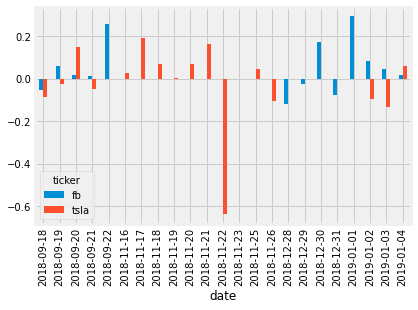

In [11]:

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
get_ipython().run_line_magic('matplotlib', 'inline')


mean_c = scored_news.groupby(['date', 'ticker']).mean()

mean_c = mean_c.unstack(level=1)

mean_c = mean_c.xs('compound', axis = 1)

mean_c.plot.bar()

## 7. Weekends and duplicates
<p>What happened to Tesla on November 22nd? Since we happen to have the headlines inside our <code>DataFrame</code>, a quick peek reveals that there are a few problems with that particular day: </p>
<ul>
<li>There are only 5 headlines for that day.</li>
<li>Two headlines are verbatim the same as another but from another news outlet.</li>
</ul>
<p>Let's clean up the dataset a bit, but not too much! While some headlines are the same news piece from different sources, the fact that they are written differently could provide different perspectives on the same story. Plus, when one piece of news is more important, it tends to get more headlines from multiple sources. What we want to get rid of is verbatim copied headlines, as these are very likely coming from the same journalist and are just being "forwarded" around, so to speak.</p>

In [12]:

num_news_before = len(scored_news.headline)
scored_news_clean = scored_news.drop_duplicates(subset = ['ticker', 'headline'])
# Count number of headlines after dropping duplicates
num_news_after = len(scored_news_clean.headline)

f"Before we had {num_news_before} headlines, now we have {num_news_after}"


'Before we had 500 headlines, now we have 476'

## 8. Sentiment on one single trading day and stock
<p>Just to understand the possibilities of this dataset and get a better feel of the data, let's focus on one trading day and one single stock. We will make an informative plot where we will see the smallest grain possible: headline and subscores.</p>

In [13]:
# <p>Just to understand the possibilities of this dataset and get a better feel of the data, let's focus on one trading day and one single stock. We will make an informative plot where we will see the smallest grain possible: headline and subscores.</p>

# In[182]:


# Set the index to ticker and date
single_day = scored_news_clean.set_index(['ticker', 'date'])
# Cross-section the fb row
single_day = single_day.loc['fb']
# Select the 3rd of January of 2019
single_day = single_day.loc['2019-01-03']
# Convert the datetime string to just the time
single_day['time'] = pd.to_datetime(single_day['time'])
single_day['time'] = single_day.time.dt.time
# Set the index to time and 
single_day = single_day.set_index('time')
# Sort it
single_day = single_day.sort_index()


## 9. Visualize the single day
<p>We will make a plot to visualize the positive, negative and neutral scores for a single day of trading and a single stock. This is just one of the many ways to visualize this dataset.</p>

<AxesSubplot:title={'center':'Positive, negative and neutral sentiment for FB on 2019-01-03'}, xlabel='time'>

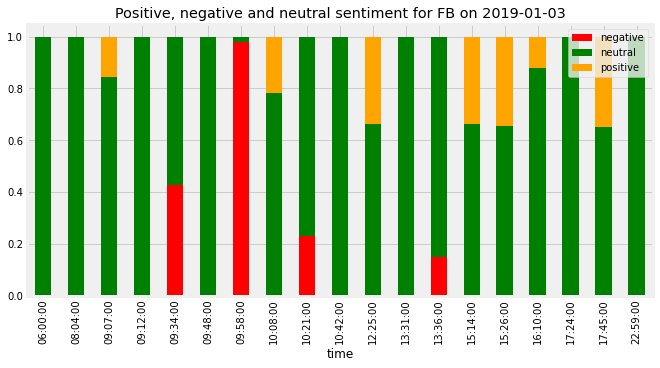

In [14]:

# In[184]:


TITLE = "Positive, negative and neutral sentiment for FB on 2019-01-03"
COLORS = ["red","green", "orange"]
# Drop the columns that aren't useful for the plot
plot_day = single_day.drop(['compound', 'headline'], axis = 1)
# Change the column names to 'negative', 'positive', and 'neutral'
plot_day.columns = ['negative','neutral', 'positive']
# Plot a stacked bar chart
plot_day.plot.bar(stacked=True, figsize=(10,5), title = TITLE, color = COLORS)

